# Introduction
## 6.1  Define the Task

#### Dataset Information
Dataset will be the cifar100 dataset from tensorflow. This is a multi-class classification problem with 100 different classes of images to be classified. There are 500 training images and 100 testing images for each of the 100 classes so this is a balanced dataset.

#### Accuracy Metric
Balanced classification problems such as this a good measure of success will be accuracy and area under the reciever operating characteristic curve. Guessing all one type of class would lead to an accuracy of 1% since there are 100 different classes. 

#### Evaluation
The model will be evaluated using a holdout test set of 10,000 images consisting of 100 of each class. The training set will consist of 500 images of each class for a total of 50,000 images.




In [ ]:
### Show data class information metrics
## show that the counts of the labels are balanced

In [1]:
from tensorflow.keras.datasets import cifar10


This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).

## 6.2 Develop a Model
### Data Preparation

The data consists of images that are 32x32.  There are 50,000 training images and 10,000 test images. 

## Examine the data

In [2]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170498071/170498071 [==============================] - 20s 0us/step


In [3]:
print('tensor shape')
print('\ttraining images:', train_images.shape)
print('\ttraining labels:', train_labels.shape)
print('\ttraining images:', train_images.dtype)
print('\ttraining labels:', train_labels.dtype)
print('\ttest images:', test_images.shape)
print('\ttest labels:', test_labels.shape)

tensor shape
	training images: (50000, 32, 32, 3)
	training labels: (50000, 1)
	training images: uint8
	training labels: uint8
	test images: (10000, 32, 32, 3)
	test labels: (10000, 1)


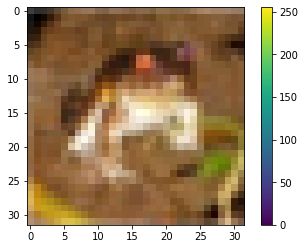

In [4]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

## Preprocess
1. Reshape to flatten 32x32x3 to vector
2. Cast vector as floats
3. Rescale from [0,1]

In [5]:
train_images_flat = train_images.reshape((50000, 32*32*3)).astype('float32') / 255.
test_images_flat = test_images.reshape((10000, 32*32*3)).astype('float32') / 255.


In [6]:
train_labels

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [7]:
from tensorflow.keras.utils import to_categorical

orig_label = train_labels[0]
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


In [8]:
print('\'', orig_label, '\'', 'as one-hot vector:\n', train_labels[0], sep='')

'[6]'as one-hot vector:
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


### Baseline Model
Start smal, smallest amout of layers can do and small # of units then increase size

Only a baseline model if it has "statistical power" meaning ??

**Selecting loss function**
Chose categorical crossentropy but why?
General loss function for classification tasks where the evaluation metric is RCO AUC - need to figure out why that is. Used as a proxy, hope is that the lower the crossentropy the higher the ROC AUC will be 

**Final Layer**  
Multi-class single label classification => 
* last layer activation: **softmax**  
* Loss function: **categorical_crossentropy**


In [11]:
# build
from tensorflow.keras import models, layers

# create empty network
network = models.Sequential()

# add 2 layers
network.add(layers.Dense(64, activation='relu', input_shape=(32 * 32 * 3, )))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='rmsprop',
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

network.fit(train_images_flat, train_labels, epochs=5, validation_split=0.2)

Epoch 1/5
1250/1250 [==============================] - 5s 4ms/step - loss: 2.0145 - accuracy: 0.2722 - val_loss: 1.9388 - val_accuracy: 0.3057
Epoch 2/5
1250/1250 [==============================] - 4s 4ms/step - loss: 1.8560 - accuracy: 0.3305 - val_loss: 1.8871 - val_accuracy: 0.3405
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 1.7998 - accuracy: 0.3555 - val_loss: 1.7730 - val_accuracy: 0.3662
Epoch 4/5
1250/1250 [==============================] - 4s 3ms/step - loss: 1.7642 - accuracy: 0.3650 - val_loss: 1.7427 - val_accuracy: 0.3855
Epoch 5/5
1250/1250 [==============================] - 4s 3ms/step - loss: 1.7425 - accuracy: 0.3769 - val_loss: 1.8456 - val_accuracy: 0.3502


Base model has achieved an 12.2% accuracy which is higher than 10% if we were to randomly guess so this is a suitable base model upon which to attempt to improve.

### 6.2.4 Develop a model that overfits
Once have model with statistical power => question is now is model sufficiently powerful?  
Enough layers? Enough Parameters? to properly model problem at hand  
Universal tension in ML is optimization vs generalization  

To figure out how big a model must develop model that overfits  
1. Add layers
2. make layers bigger
3. train for more epochs

Monitor the training loss and validation loss as well as training and validation values for any metrics that you care about  

**Overfitting:** Once see that model's performance on validation data begins to degrade


Run a 2 layer model layer with large units. 
Train for 30 epochs to see where overfitting starts to occur. 


In [12]:
from keras.callbacks import CSVLogger
import keras 

def build_network_rmsprop_opt(units_list, learning_rate=0.01, epochs=5):
    network = models.Sequential()
    
    #first layer - needs input_shape
    network.add(layers.Dense(units_list[0], activation='relu', input_shape=(32 * 32 * 3, )))
    
    #middle layers
    for units in units_list[1:]:
        network.add(layers.Dense(units, activation='relu'))
    
    #last layer
    network.add(layers.Dense(101, activation='softmax'))
    
    
    network.compile(optimizer=keras.optimizers.RMSprop(learning_rate),
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    log_name = log_name + '.csv'
    history = network.fit(
        train_images_flat, train_labels, 
        epochs=epochs, 
        verbose=2,
        validation_split=0.2
    )

    return history

In [13]:


def build_network_adam_opt(units_list, learning_rate=0.01, epochs=5):
    network = models.Sequential()
    
    #first layer - needs input_shape
    network.add(layers.Dense(units_list[0], activation='relu', input_shape=(32 * 32 * 3, )))
    
    #middle layers
    for units in units_list[1:]:
        network.add(layers.Dense(units, activation='relu'))
    
    #last layer
    network.add(layers.Dense(10, activation='softmax'))
    
    
    network.compile(optimizer=keras.optimizers.Adam(learning_rate),
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

    history = network.fit(
        train_images_flat, train_labels, 
        epochs=epochs, 
        verbose=2,
        validation_split=0.2
    )

    return history

In [15]:
def build_network(units_list, epochs=15, log_name='log', optimizer='rmsprop'):
    network = models.Sequential()
    
    #first layer - needs input_shape
    network.add(layers.Dense(units_list[0], activation='relu', input_shape=(32 * 32 * 3, )))
    
    #middle layers
    for units in units_list[1:]:
        network.add(layers.Dense(units, activation='relu'))
    
    #last layer
    network.add(layers.Dense(10, activation='softmax'))
    
    
    network.compile(optimizer=optimizer,
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

    history = network.fit(
        train_images_flat, train_labels, 
        epochs=epochs, 
        verbose=0,
        validation_split=0.2
    )

    return history

In [16]:
def plot_train_val_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.plot(epochs, loss, blue_dots, label = 'Training loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
def plot_train_val_acc(history):
    plt.clf()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
        
    epochs = range(1, len(acc) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
        
    plt.plot(epochs, acc, blue_dots, label = 'Training acc')
    plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [17]:
def compare_loss(hist1, hist2, title1, title2): 
    min_epochs = min(len(hist1.history['loss']), len(hist2.history['loss']))
    loss = hist1.history['loss'][:min_epochs]
    val_loss = hist1.history['val_loss'][:min_epochs]
    loss_drop = hist2.history['loss']
    val_loss_drop = hist2.history['val_loss']

    epochs = range(1, min_epochs + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    plt.plot(epochs, loss, blue_dots, label = f'{title1} Training loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = f'{title1} Validation loss')
    plt.plot(epochs, loss_drop, red_dots, label = f'{title2} Training loss')
    plt.plot(epochs, val_loss_drop, solid_red_line, label = f'{title2} Validation loss')
    # plt.title('Loss With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def compare_acc(hist1, hist2, title1, title2): 
    min_epochs = min(len(hist1.history['accuracy']), len(hist2.history['accuracy']))
    acc = hist1.history['accuracy'][:min_epochs]
    val_acc = hist1.history['val_accuracy'][:min_epochs]
    acc_drop = hist2.history['accuracy']
    val_acc_drop = hist2.history['val_accuracy']

    epochs = range(1, min_epochs + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    plt.plot(epochs, acc, blue_dots, label = f'{title1} Training accuracy')
    plt.plot(epochs, val_acc, solid_blue_line, label = f'{title1} Validation accuracy')
    plt.plot(epochs, acc_drop, red_dots, label = f'{title2} Training acc')
    plt.plot(epochs, val_acc_drop, solid_red_line, label = f'{title2} Validation acc')
    # plt.title('Accuracy With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


Plot Training and Validation Loss and Training and Validation Accuracy

In [18]:
init_1_layer_history = build_network([512], 15)

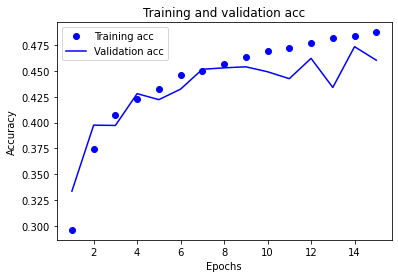

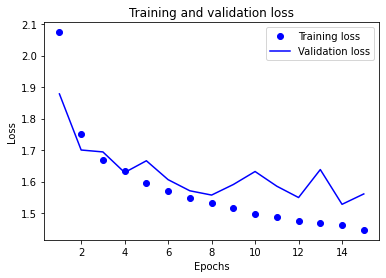

In [19]:
plot_train_val_acc(init_1_layer_history)
plot_train_val_loss(init_1_layer_history)

Build a 2 layer network and overfit

In [20]:
init_2_layer_history = build_network([512, 512], 15)


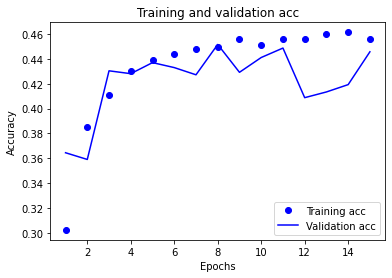

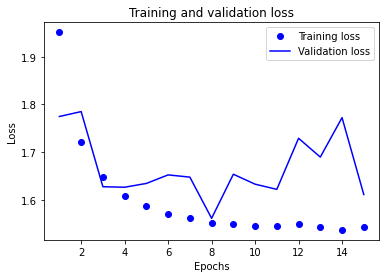

In [21]:
plot_train_val_acc(init_2_layer_history)
plot_train_val_loss(init_2_layer_history)

Compare 1 and 2 layer network

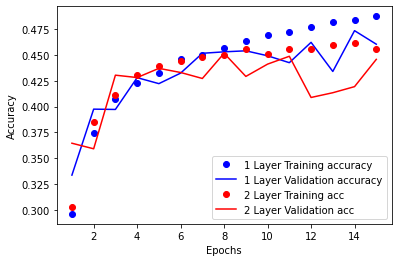

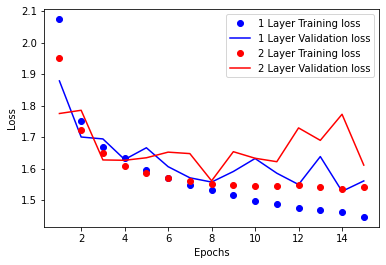

In [22]:
compare_acc(init_1_layer_history, init_2_layer_history, '1 Layer', '2 Layer')
compare_loss(init_1_layer_history, init_2_layer_history, '1 Layer', '2 Layer')

In [24]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices


Num GPUs Available:  0


<function tensorflow.python.framework.config.list_physical_devices(device_type=None)>

Can see that a 2 layer network is much more accurate than a 1 layer network.

Build a 2 layer network using the 'adam' optimizer instead of rmsprop and overfit for 30 epochs and compare to the 'rmsprop' optimizer model. 

In [ ]:
init_2_layer_adam_history = build_network([512, 512], 15, optimizer='adam')

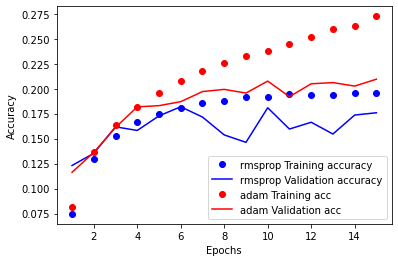

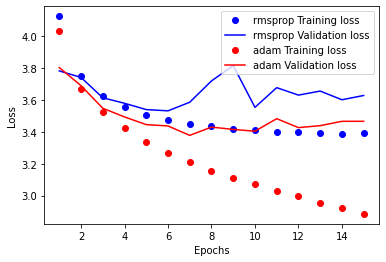

In [ ]:
compare_acc(init_2_layer_history, init_2_layer_adam_history, 'rmsprop', 'adam')
compare_loss(init_2_layer_history, init_2_layer_adam_history, 'rmsprop', 'adam')

When comparing the use of the rmsprop optimizer compared to the adam optimizer the plots show that the adam optimizer outperforms rmsprop. 

Build a 3 layer network and overfit for 30 epochs to compare to 2 layer model.

In [ ]:
init_3_layer_history_adam = build_network([512, 512, 512], 15, optimizer='adam')


Compare the training and validation accuracies and losses of 2 models. 

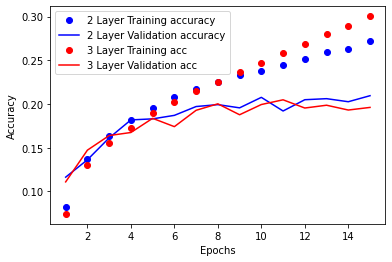

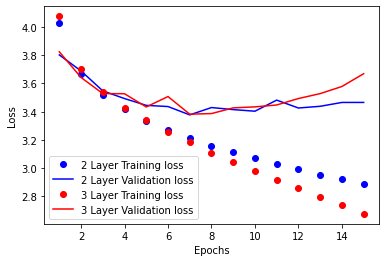

In [ ]:
compare_acc(init_2_layer_adam_history, init_3_layer_history_adam, '2 Layer', '3 Layer')
compare_loss(init_2_layer_adam_history, init_3_layer_history_adam, '2 Layer', '3 Layer')

**2 vs 3 Layer Model**   
Validation Accuracy for a 2 layer peaks around 7 epochs while a 3 layer model peaks around 9 epochs. The 3 layer model has a slightly higher accuracy. Looking at the loss for the 2 models the loss for the 3 layer model is lower than a 2 layer model and again is at its minimum at 9 epochs. 

---



## Hyperparameter search space
**Layers**  
1,2  
**Units**  
[64, 128, 512, 1024]  
**Learning Rate**  
[0.001, 0.01, 0.1, 0.5]

In [ ]:
unit_space = [128, 512, 1024]
learning_rate_space = [0.0001, 0.001, 0.01]
layer_space = [2,3]


In [ ]:
def get_search_grid(unit_space, learning_rate_space, layer_space):
    search_space = []
    # for units in unit_space:
    #     for lr in learning_rate_space:
    #         search_space.append([[units], lr])
    # space1_len = len(search_space)
    # print('Search layer 1 length: ', space1_len)
    for units1 in unit_space:
        for units2 in unit_space:
            for lr in learning_rate_space:
                search_space.append([[units1, units2],lr])
    space2_len = len(search_space)
    print('Search layer 2 length: ', space2_len)
    for u1 in unit_space:
        for u2 in unit_space:
            for u3 in unit_space:
                for lr in learning_rate_space:
                    search_space.append([[u1, u2, u3], lr])
    space3_len = len(search_space) - space2_len
    print('Search layer 3 length: ', space3_len)
    return search_space

search_space = get_search_grid(unit_space, learning_rate_space, layer_space)

Search layer 2 length:  27
Search layer 3 length:  81


In [ ]:
# use this to break down search space so don't have to run so long
search_space_1 = search_space[:15]
search_space_2 = search_space[15: 90]
# search_space_3 = search_space[90:]

In [ ]:
def run_grid_search(search_space, log_name, epochs):
    histories = []
    count = 0
    for params in search_space:
        history = build_network_adam_opt(params[0], params[1], epochs=epochs, log_name=log_name)
        histories.append(history.history)
        count = count + 1
        print(count)
    return histories

In [ ]:
grid_search_histories = run_grid_search(search_space, 'log6', 7)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108


In [ ]:
import numpy as np

def get_max_hist_index2(hist):
    last_values = []
    for val in hist:
        last_values.append(val[-1])
    index_max = np.argmax(last_values)
    return index_max


def print_best_params2(params, hist):
    layers = params[0]
    lr = params[1]
    layers_text = ''
    for count, layer in enumerate(layers):
        layers_text = layers_text + 'Layer #' + str(count + 1) + ' units:' + str(layer) + '\t'
    print(layers_text, '\t', 'Learning Rate: ', lr)
    print('Accuracy: ', round(hist['val_accuracy'][-1]*100, 2), '%')

def get_max_params2(search_space, histories):
    validation_accuracies = []
    for hist in histories:
        validation_accuracies.append(hist['val_accuracy'])
    max_index = get_max_hist_index2(validation_accuracies)
    print('Max accuracy index: ', max_index)
    
    max_val_acc_hist = histories[max_index]
    # max_val_loss = loss_val_hist[max_index]
    params = search_space[max_index]
    
    print_best_params2(params, max_val_acc_hist)
    return params, max_val_acc_hist
 


Get best number of layers and paramaters given by the validation accuracy from the grid search.

In [ ]:
best_params_val, best_hist = get_max_params2(search_space, grid_search_histories)

Max accuracy index:  105
Layer #1 units:1024	Layer #2 units:1024	Layer #3 units:1024	 	 Learning Rate:  0.0001
Accuracy:  22.77 %


In [ ]:
import csv

def save_histories_to_file(histories, search_space, file_name):
    all_data = []
    for i, hist in enumerate(histories):
        row = [hist['accuracy'], hist['val_accuracy'], hist['loss'], hist['val_loss'], search_space[i][0], search_space[i][1]]
        all_data.append(row)
        
    with open(file_name, 'w') as f:
        write = csv.writer(f)
        write.writerow(['acc_train', 'acc_val', 'loss_train','loss_val', 'layers_units', 'learning_rate'])
        write.writerows(all_data)
    return

save_histories_to_file(grid_search_histories, search_space, 'hist_csv.csv')

Best Model was a 3 layer [1024,1024, 1024] units and a learning rate of 0.001.
So the best model used the max amount of units for each layer and the lowest learning rate. 

New grid search to maximize validation accuracy and min validation loss rather than training. 

Find the best paramaters were a 2 layer model with first layer having 1024 units and second having 64 with a learning rate of 0.01. 

### Try Overfitting
Run for 15 epochs

In [ ]:
best_network_hist = build_network_adam_opt(best_params_val[0], best_params_val[1], 20)

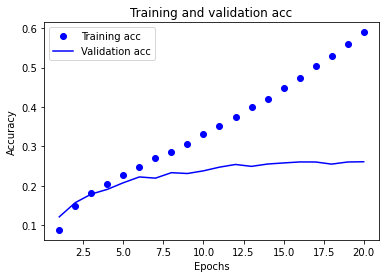

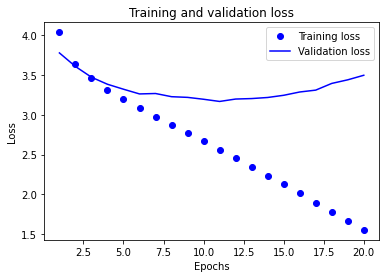

In [ ]:
plot_train_val_acc(best_network_hist)
plot_train_val_loss(best_network_hist)

Training accuracy continues to increase while validation accuracy levels off around 12 epochs. After this we get overfitting.

This is in line with the validation loss which stops decreasing around 12 epochs as well while training loss steadily decreases past this point confirming that overfitting has been achieved. 

### 6.2.5 Hyperparamater tuning

goal now is to maximize generalization performance  
repeatedly modify model and train it and evaluate it (**on evaluation data NOT test data**)  



**Search Space**
1. learning rate - already tuned for, could look more deeply at this
2. units - also already tuned for in the grid search but could again increase units
3. layers
    ii. add or remove layers
4. add dropout

In [ ]:

def build_network_w_dropout(units_list, learning_rate=0.01, epochs=12, dropout_rate=0.3):
    network = models.Sequential()
    
    #first layer - needs input_shape
    network.add(layers.Dense(units_list[0], activation='relu', input_shape=(32 * 32 * 3, )))
    network.add(layers.Dropout(dropout_rate))
    
    #middle layers
    for units in units_list[1:]:
        network.add(layers.Dense(units, activation='relu'))
        network.add(layers.Dropout(dropout_rate))
    
    #last layer
    network.add(layers.Dense(100, activation='softmax'))
    
    
    network.compile(optimizer=keras.optimizers.Adam(learning_rate),
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

    csv_logger = CSVLogger('log.csv', append=True, separator=',')
    history = network.fit(
        train_images_flat, train_labels, 
        epochs=epochs, 
        verbose=0,
        callbacks=[csv_logger],
        validation_split=0.2
    )

    return history

In [ ]:
best_network_w_drop_hist = build_network_w_dropout(best_params_val[0], best_params_val[1], 12)

Compare without dropout

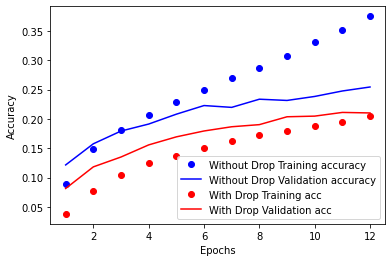

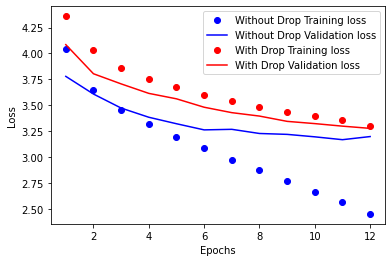

In [ ]:
compare_acc(best_network_hist,best_network_w_drop_hist, 'Without Drop', 'With Drop')
compare_loss(best_network_hist,best_network_w_drop_hist, 'Without Drop', 'With Drop')

Can see from the results that including dropout layers does not improve model accuracy, both training accuracy and validation accuracy decrease. Also training loss and validation loss also increase with the inclusion of dropout layers. 

The addition of dropout layers did not improve the model. 

Check if the addition of another dense layer improves the model at all. 

In [ ]:
best_network_4_layers_hist = build_network_adam_opt([1024,1024,1024,1024], best_params_val[1], epochs=12)

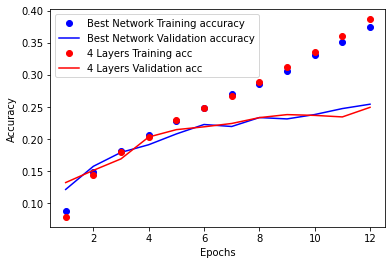

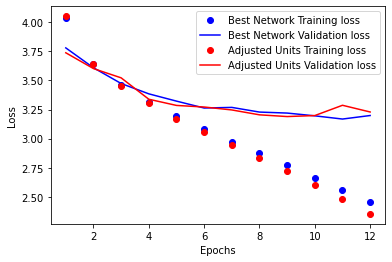

In [ ]:
compare_acc(best_network_hist,best_network_4_layers_hist, 'Best Network', '4 Layers')
compare_loss(best_network_hist,best_network_4_layers_hist, 'Best Network', 'Adjusted Units')

Try a lower learning rate with 3 layers

In [ ]:
best_network_lower_lr_hist = build_network_adam_opt([1024,1024,1024], 0.0001, epochs=12)

Experiment with no learning rate since in theory adam optimizer auto adjusts this?

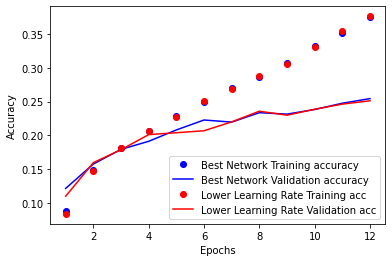

In [ ]:
compare_acc(best_network_hist,best_network_lower_lr_hist, 'Best Network', 'Lower Learning Rate')

No noticable gain from a lower learning rate so leave at 0.001. 

Still find that original best network having the best success. Biggest issue is that this is a network with a middle layer of 64 units which is less than the final layer of 100 units which could be causing a bottleneck, however still getting the best results. 

In [ ]:

def build_network_w_batchsize(units_list, learning_rate=0.001, epochs=5, log_name='log', batch_size=128):
    network = models.Sequential()
    
    #first layer - needs input_shape
    network.add(layers.Dense(units_list[0], activation='relu', input_shape=(32 * 32 * 3, )))
    
    #middle layers
    for units in units_list[1:]:
        network.add(layers.Dense(units, activation='relu'))
    
    #last layer
    network.add(layers.Dense(100, activation='softmax'))
    
    
    network.compile(optimizer=keras.optimizers.Adam(learning_rate),
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    log_name = log_name + '.csv'
    csv_logger = CSVLogger(log_name, append=False, separator=',')
    history = network.fit(
        train_images_flat, train_labels, 
        epochs=epochs, 
        verbose=0,
        callbacks=[csv_logger],
        validation_split=0.2,
        batch_size=batch_size
    )

    return history

In [ ]:
best_network_batch_128_hist = build_network_w_batchsize([1024, 1024, 1024], 0.001, 12, batch_size=128)



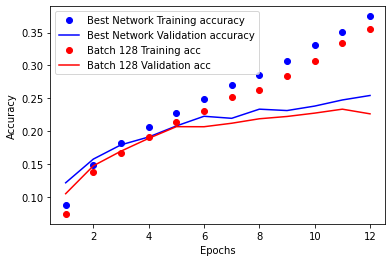

In [ ]:
compare_acc(best_network_hist,best_network_batch_128_hist, 'Best Network', 'Batch 128')

In [ ]:
best_network_batch_16_hist = build_network_w_batchsize([1024, 1024, 1024], 0.001, 12, batch_size=16)

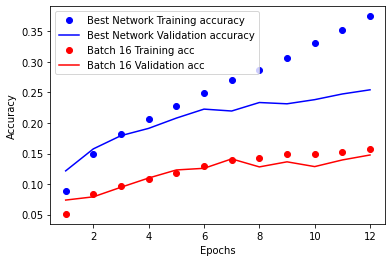

In [ ]:
compare_acc(best_network_hist,best_network_batch_16_hist, 'Best Network', 'Batch 16')

Don't see any major improvements from the adjustment of batch size

# Test Model

In [60]:
final_model = models.Sequential()
    
#first layer - needs input_shape
final_model.add(layers.Dense(1024, activation='relu', input_shape=(32 * 32 * 3, )))

#middle layers
final_model.add(layers.Dense(1024, activation='relu'))
final_model.add(layers.Dense(1024, activation='relu'))

#last layer
final_model.add(layers.Dense(100, activation='softmax'))


final_model.compile(optimizer=keras.optimizers.Adam(0.001),
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

history = final_model.fit(
    train_images_flat, train_labels, 
    epochs=12, 
    verbose=2,
)

final_results = final_model.evaluate(test_images_flat, test_labels)


Epoch 1/12
1563/1563 - 4s - loss: 4.0386 - accuracy: 0.0775 - 4s/epoch - 3ms/step
Epoch 2/12
1563/1563 - 4s - loss: 3.6465 - accuracy: 0.1372 - 4s/epoch - 2ms/step
Epoch 3/12
1563/1563 - 4s - loss: 3.4721 - accuracy: 0.1659 - 4s/epoch - 2ms/step
Epoch 4/12
1563/1563 - 4s - loss: 3.3586 - accuracy: 0.1852 - 4s/epoch - 2ms/step
Epoch 5/12
1563/1563 - 4s - loss: 3.2707 - accuracy: 0.2009 - 4s/epoch - 2ms/step
Epoch 6/12
1563/1563 - 4s - loss: 3.1988 - accuracy: 0.2121 - 4s/epoch - 2ms/step
Epoch 7/12
1563/1563 - 4s - loss: 3.1299 - accuracy: 0.2214 - 4s/epoch - 2ms/step
Epoch 8/12
1563/1563 - 4s - loss: 3.0613 - accuracy: 0.2329 - 4s/epoch - 2ms/step
Epoch 9/12
1563/1563 - 4s - loss: 2.9903 - accuracy: 0.2435 - 4s/epoch - 2ms/step
Epoch 10/12
1563/1563 - 4s - loss: 2.9267 - accuracy: 0.2545 - 4s/epoch - 2ms/step
Epoch 11/12
1563/1563 - 4s - loss: 2.8673 - accuracy: 0.2629 - 4s/epoch - 2ms/step
Epoch 12/12
1563/1563 - 4s - loss: 2.7988 - accuracy: 0.2777 - 4s/epoch - 2ms/step
313/313 [====

In [61]:
print(final_results)

[3.5501441955566406, 0.1981000006198883]
